# Intro

In statistics, kernel density estimation (KDE) is the application of kernel smoothing for probability density estimation, i.e., a non-parametric method to estimate the probability density function of a random variable based on kernels as weights. KDE answers a fundamental data smoothing problem where inferences about the population are made, based on a finite data sample. In some fields such as signal processing and econometrics it is also termed the Parzen–Rosenblatt window method, after Emanuel Parzen and Murray Rosenblatt, who are usually credited with independently creating it in its current form.One of the famous applications of kernel density estimation is in estimating the class-conditional marginal densities of data when using a naive Bayes classifier, which can improve its prediction accuracy.

Kernel density estimation, often called KDE, is a method that allows you to create a smooth curve for a dataset. So first let's figure out what a density estimate is.

In probability and statistics, density estimation is the construction of an estimate based on observational data of an unobservable basic probability density function. Density estimation refers to the mapping of data points on a curve or function that will best represent the data.

Kernel density estimation is the process of estimating an unknown probability density function using a *kernel function* $K(u)$. While a histogram counts the number of data points in somewhat arbitrary regions, a kernel density estimate is a function defined as the sum of a kernel function on every data point. The kernel function typically exhibits the following properties:
- Symmetry,
- Normalization,
- Monotonically decreasing,
- Expected value equal to zero

A univariate kernel density estimator is implemented in sm.nonparametric.KDEUnivariate. In this example we will show the following:
- Basic usage, how to fit the estimator.
- The effect of varying the bandwidth of the kernel using the bw argument.
- The various kernel functions available using the kernel argument.

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.distributions.mixture_rvs import mixture_rvs

# A univariate example

In [2]:
np.random.seed(12345)  # Seed the random number generator for reproducible results

We create a bimodal distribution: a mixture of two normal distributions with locations at `-1` and `1`.

In [3]:
# Location, scale and weight for the two distributions
dist1_loc, dist1_scale, weight1 = -1, 0.5, 0.25
dist2_loc, dist2_scale, weight2 = 1, 0.5, 0.75

# Sample from a mixture of distributions
obs_dist = mixture_rvs(
    prob=[weight1, weight2],
    size=250,
    dist=[stats.norm, stats.norm],
    kwargs=(
        dict(loc=dist1_loc, scale=dist1_scale),
        dict(loc=dist2_loc, scale=dist2_scale),
    ),
)

The simplest non-parametric technique for density estimation is the histogram.

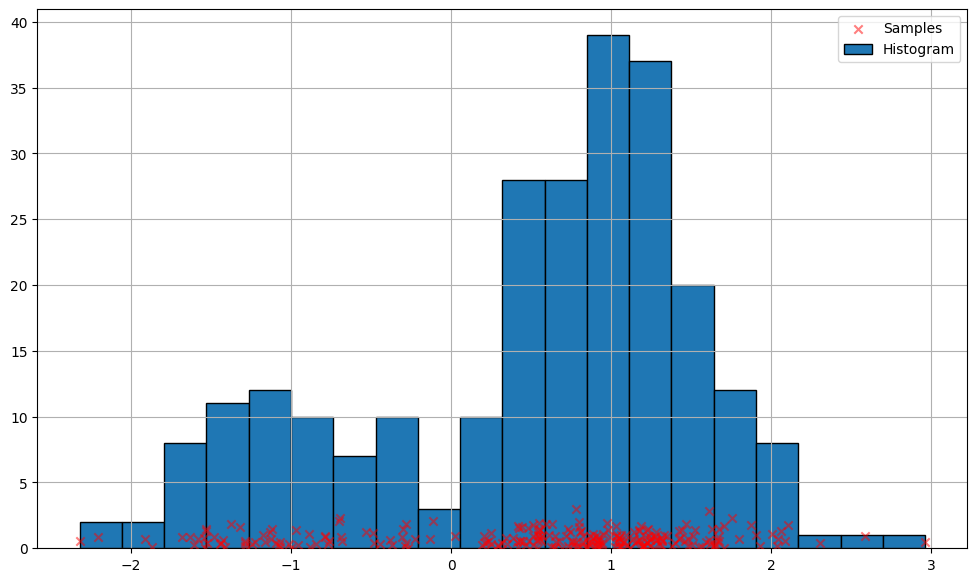

In [4]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

# Scatter plot of data samples and histogram
ax.scatter(
    obs_dist,
    np.abs(np.random.randn(obs_dist.size)),
    zorder=15,
    color="red",
    marker="x",
    alpha=0.5,
    label="Samples",
)
lines = ax.hist(obs_dist, bins=20, edgecolor="k", label="Histogram")

ax.legend(loc="best")
ax.grid(True, zorder=-5)

# Fitting with the default arguments
The histogram above is discontinuous. To compute a continuous probability density function, we can use kernel density estimation.

We initialize a univariate kernel density estimator using `KDEUnivariate`.

In [5]:
kde = sm.nonparametric.KDEUnivariate(obs_dist)
kde.fit()  # Estimate the densities

We present a figure of the fit, as well as the true distribution.

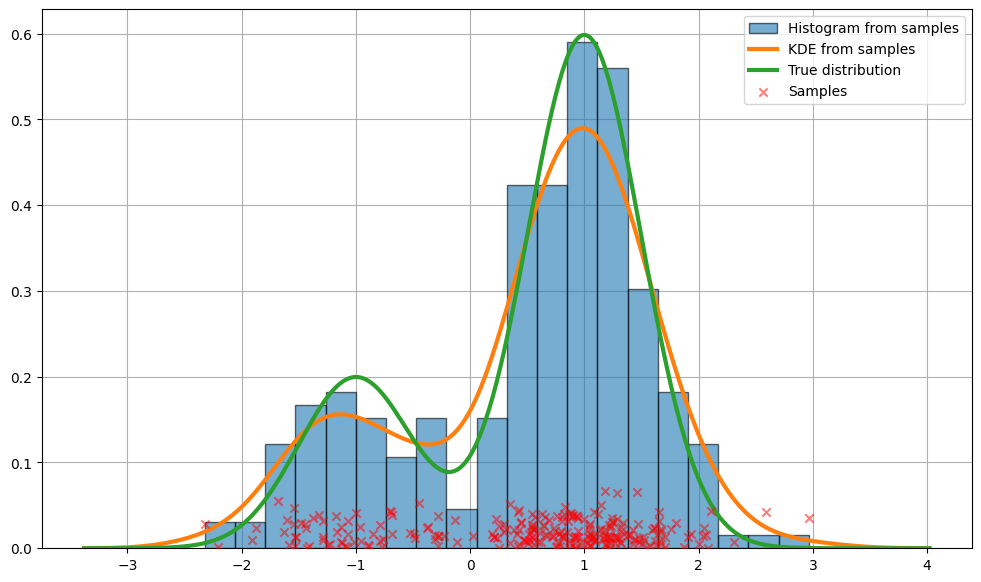

In [6]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

# Plot the histogram
ax.hist(
    obs_dist,
    bins=20,
    density=True,
    label="Histogram from samples",
    zorder=5,
    edgecolor="k",
    alpha=0.6,
)

# Plot the KDE as fitted using the default arguments
ax.plot(kde.support, kde.density, lw=3, label="KDE from samples", zorder=10)

# Plot the true distribution
true_values = (
    stats.norm.pdf(loc=dist1_loc, scale=dist1_scale, x=kde.support) * weight1
    + stats.norm.pdf(loc=dist2_loc, scale=dist2_scale, x=kde.support) * weight2
)
ax.plot(kde.support, true_values, lw=3, label="True distribution", zorder=15)

# Plot the samples
ax.scatter(
    obs_dist,
    np.abs(np.random.randn(obs_dist.size)) / 40,
    marker="x",
    color="red",
    zorder=20,
    label="Samples",
    alpha=0.5,
)

ax.legend(loc="best")
ax.grid(True, zorder=-5)

In the code above, default arguments were used. We can also vary the bandwidth of the kernel, as we will now see.

# Varying the bandwidth using the bw argument
The bandwidth of the kernel can be adjusted using the bw argument. In the following example, a bandwidth of `bw=0.2` seems to fit the data well.

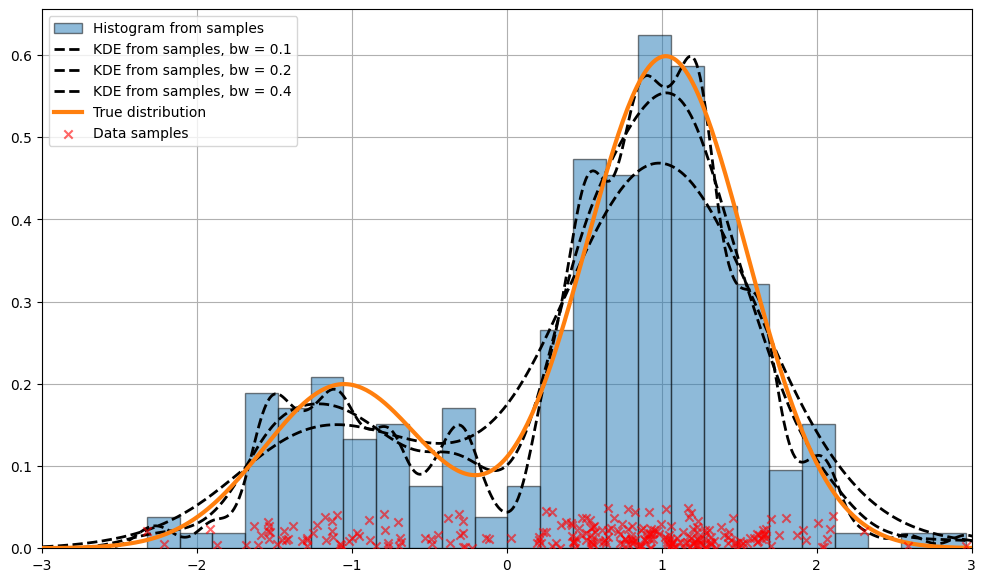

In [7]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

# Plot the histogram
ax.hist(
    obs_dist,
    bins=25,
    label="Histogram from samples",
    zorder=5,
    edgecolor="k",
    density=True,
    alpha=0.5,
)

# Plot the KDE for various bandwidths
for bandwidth in [0.1, 0.2, 0.4]:
    kde.fit(bw=bandwidth)  # Estimate the densities
    ax.plot(
        kde.support,
        kde.density,
        "--",
        lw=2,
        color="k",
        zorder=10,
        label="KDE from samples, bw = {}".format(round(bandwidth, 2)),
    )

# Plot the true distribution
ax.plot(kde.support, true_values, lw=3, label="True distribution", zorder=15)

# Plot the samples
ax.scatter(
    obs_dist,
    np.abs(np.random.randn(obs_dist.size)) / 50,
    marker="x",
    color="red",
    zorder=20,
    label="Data samples",
    alpha=0.6,
)

ax.legend(loc="best")
ax.set_xlim([-3, 3])
ax.grid(True, zorder=-5)

# Comparing kernel functions
In the example above, a Gaussian kernel was used. Several other kernels are also available.

In [8]:
from statsmodels.nonparametric.kde import kernel_switch

list(kernel_switch.keys())

['gau', 'epa', 'uni', 'tri', 'biw', 'triw', 'cos', 'cos2', 'tric']

## The available kernel functions

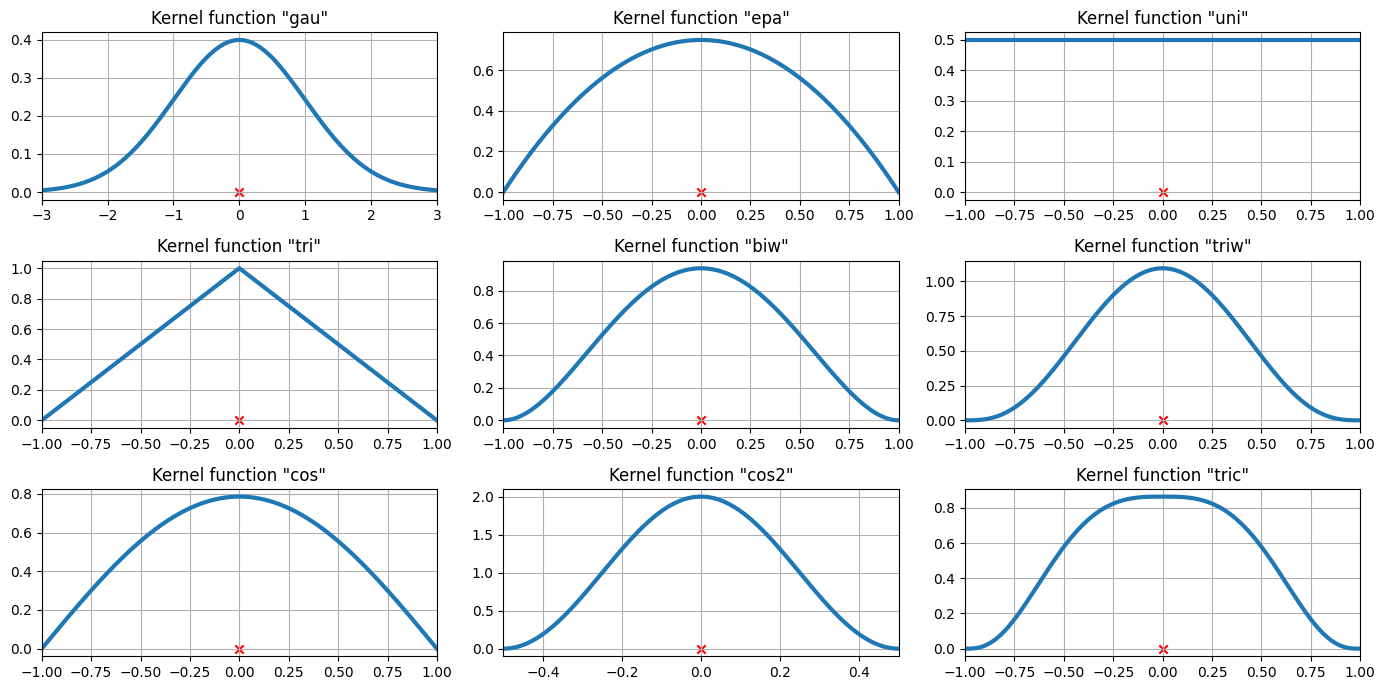

In [9]:
# Create a figure
fig = plt.figure(figsize=(14, 7))

# Enumerate every option for the kernel
for i, (ker_name, ker_class) in enumerate(kernel_switch.items()):

    # Initialize the kernel object
    kernel = ker_class()

    # Sample from the domain
    domain = kernel.domain or [-3, 3]
    x_vals = np.linspace(*domain, num=2 ** 10)
    y_vals = kernel(x_vals)

    # Create a subplot, set the title
    ax = fig.add_subplot(3, 3, i + 1)
    ax.set_title('Kernel function "{}"'.format(ker_name))
    ax.plot(x_vals, y_vals, lw=3, label="{}".format(ker_name))
    ax.scatter([0], [0], marker="x", color="red")
    plt.grid(True, zorder=-5)
    ax.set_xlim(domain)

plt.tight_layout()

## The available kernel functions on three data points
We now examine how the kernel density estimate will fit to three equally spaced data points.

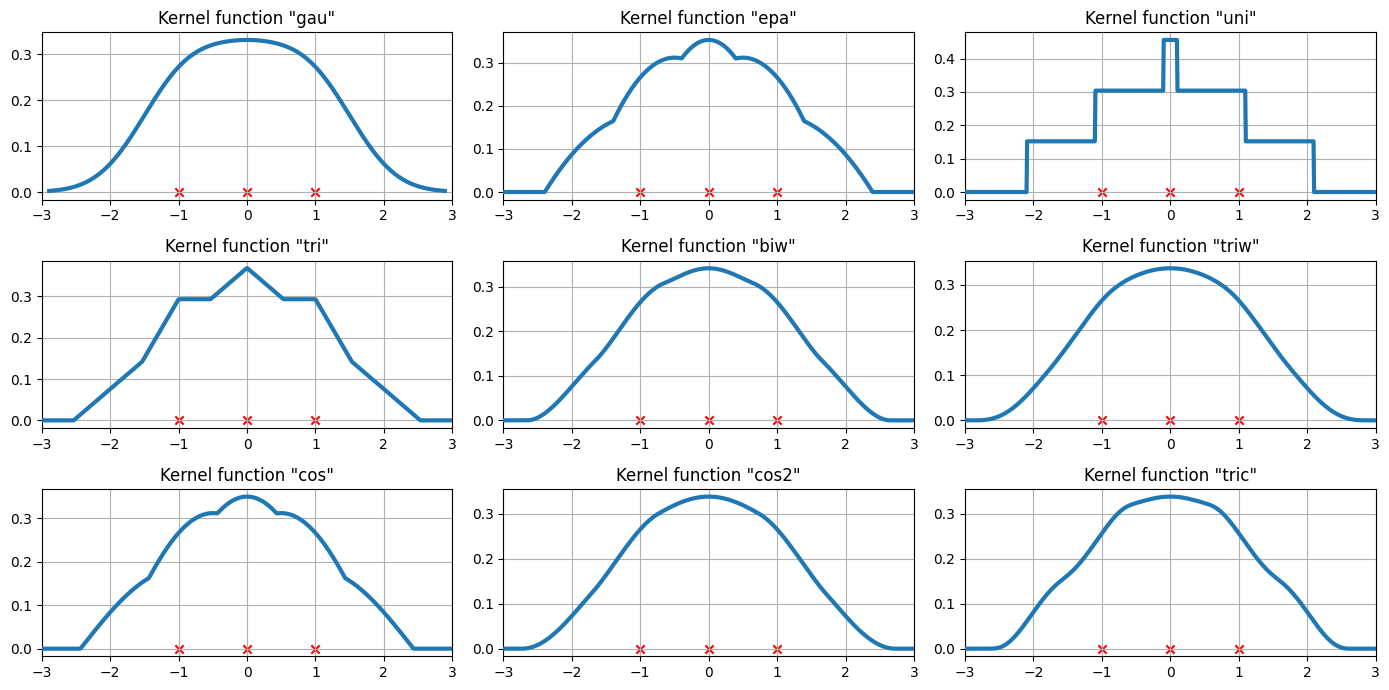

In [10]:
# Create three equidistant points
data = np.linspace(-1, 1, 3)
kde = sm.nonparametric.KDEUnivariate(data)

# Create a figure
fig = plt.figure(figsize=(14, 7))

# Enumerate every option for the kernel
for i, kernel in enumerate(kernel_switch.keys()):

    # Create a subplot, set the title
    ax = fig.add_subplot(3, 3, i + 1)
    ax.set_title('Kernel function "{}"'.format(kernel))

    # Fit the model (estimate densities)
    kde.fit(kernel=kernel, fft=False, gridsize=2 ** 10)

    # Create the plot
    ax.plot(kde.support, kde.density, lw=3, label="KDE from samples", zorder=10)
    ax.scatter(data, np.zeros_like(data), marker="x", color="red")
    plt.grid(True, zorder=-5)
    ax.set_xlim([-3, 3])

plt.tight_layout()

# A more difficult case
The fit is not always perfect. See the example below for a harder case.

In [11]:
obs_dist = mixture_rvs(
    [0.25, 0.75],
    size=250,
    dist=[stats.norm, stats.beta],
    kwargs=(dict(loc=-1, scale=0.5), dict(loc=1, scale=1, args=(1, 0.5))),
)

In [12]:
kde = sm.nonparametric.KDEUnivariate(obs_dist)
kde.fit()

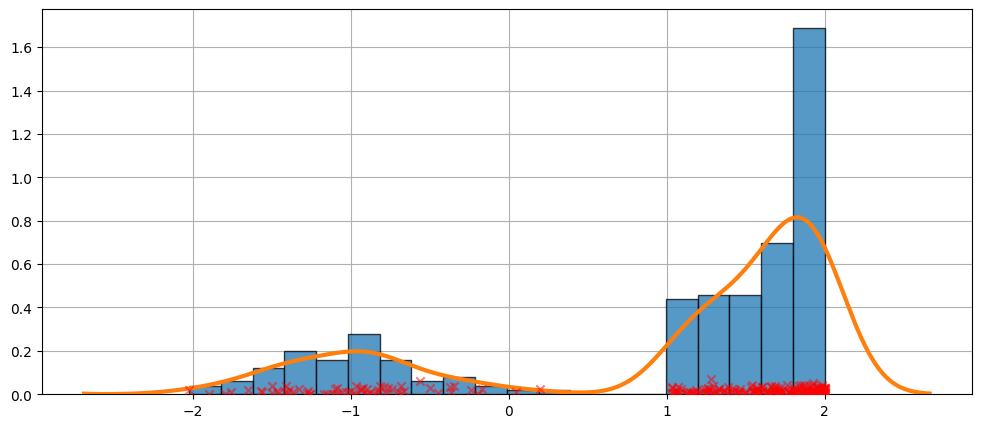

In [13]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.hist(obs_dist, bins=20, density=True, edgecolor="k", zorder=4, alpha=0.75)
ax.plot(kde.support, kde.density, lw=3, zorder=7)
# Plot the samples
ax.scatter(
    obs_dist,
    np.abs(np.random.randn(obs_dist.size)) / 50,
    marker="x",
    color="red",
    zorder=20,
    label="Data samples",
    alpha=0.5,
)
ax.grid(True, zorder=-5)

# The KDE is a distribution
Since the KDE is a distribution, we can access attributes and methods such as:

`entropy`

`evaluate`

`cdf`

`icdf`

`sf`

`cumhazard`

In [14]:
obs_dist = mixture_rvs(
    [0.25, 0.75],
    size=1000,
    dist=[stats.norm, stats.norm],
    kwargs=(dict(loc=-1, scale=0.5), dict(loc=1, scale=0.5)),
)
kde = sm.nonparametric.KDEUnivariate(obs_dist)
kde.fit(gridsize=2 ** 10)

In [15]:
kde.entropy

1.314324140492138

In [16]:
kde.evaluate(-1)

array([0.18085886])

## Cumulative distribution, it’s inverse, and the survival function

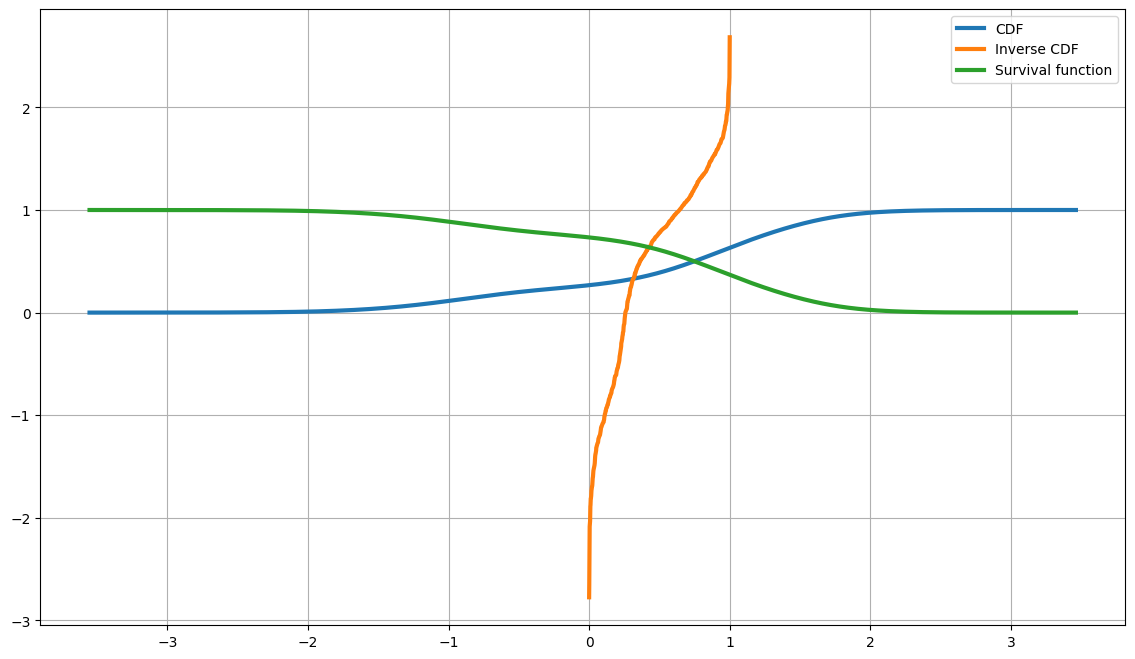

In [17]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

ax.plot(kde.support, kde.cdf, lw=3, label="CDF")
ax.plot(np.linspace(0, 1, num=kde.icdf.size), kde.icdf, lw=3, label="Inverse CDF")
ax.plot(kde.support, kde.sf, lw=3, label="Survival function")
ax.legend(loc="best")
ax.grid(True, zorder=-5)

## The Cumulative Hazard Function

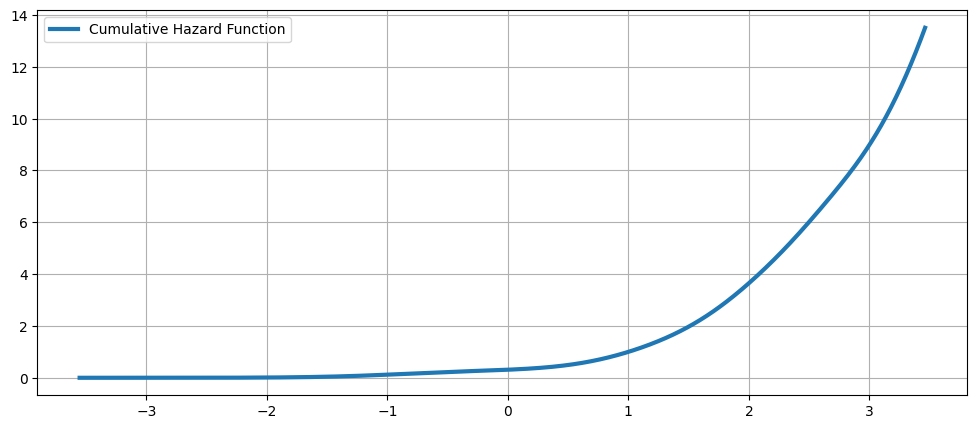

In [18]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.plot(kde.support, kde.cumhazard, lw=3, label="Cumulative Hazard Function")
ax.legend(loc="best")
ax.grid(True, zorder=-5)

# Conclusion 

The smoothing problem is often used in Data Science, because this method allows you to create a smoothed curve. This feature is especially useful in project modeling and object modeling.

KDE works by plotting the data and starting to create a distribution curve. The curve is calculated by weighing the distance between all points at each specific location of the distribution. If there are more points grouped locally, the score is higher, since the probability of seeing a point in this location is

Reference
* Rosenblatt, M. "Remarks on Some Nonparametric Estimates of a Density Function". The Annals of Mathematical Statistics. 
* Parzen, E. "On Estimation of a Probability Density Function and Mode". The Annals of Mathematical Statistics. 
* Piryonesi S. Madeh; El-Diraby Tamer E. "Role of Data Analytics in Infrastructure Asset Management: Overcoming Data Size and Quality Problems". Journal of Transportation Engineering.
